In [30]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [31]:
n_epochs = 30   # Number of optimization epochs
n_layers = 2    # Number of random layers
n_train = 1000    # Size of the train dataset
n_test = 300   # Size of the test dataset
num_filters = 20

SAVE_PATH = "../../research_data/qnn_data/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [32]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [33]:
dev = qml.device("lightning.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    # print("qml.RY(np.pi * phi[j], wires = j") 
    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [34]:
def quanv(image, num_filters):
    """Convolves the input image with many applications of the same quantum circuit."""
    tot = np.zeros((14, 14, 4, num_filters))
    
    for i in range(num_filters):
        out = np.zeros((14, 14, 4))
    
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        for j in range(0, 28, 2):
            for k in range(0, 28, 2):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = circuit(
                    [
                        image[j, k, 0],
                        image[j, k + 1, 0],
                        image[j + 1, k, 0],
                        image[j + 1, k + 1, 0]
                    ]
                )
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(4):
                    tot[j // 2, k // 2, c, i] = q_results[c]
    return tot

In [35]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        # _q_train_images = np.array_split(quanv(img, num_filters), num_filters, axis = 3)
        # print(_q_train_images[0].shape)
        for img in quanv(img, num_filters):
            q_train_images.append(img)
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        # _q_test_images = np.array_split(quanv(img, num_filters), num_filters, axis = 3)
        for img in quanv(img, num_filters):
            q_test_images.append(img)
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


Quantum pre-processing of train images:
1000/1000        
Quantum pre-processing of test images:


In [36]:
print(q_train_images.shape)
q_train_images = q_train_images.reshape((n_train, 14, 14, 4 * num_filters))
print(q_train_images.shape)


(14000, 14, 4, 20)
(1000, 14, 14, 80)


In [37]:
print(q_test_images.shape)
q_test_images = q_test_images.reshape((n_test, 14, 14, 4 * num_filters))
print(q_test_images.shape)

(4200, 14, 4, 20)
(300, 14, 14, 80)


In [38]:
# n_samples = 4
# n_channels = 4 * num_filters
# fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
# for k in range(n_samples):
#     axes[0, 0].set_ylabel("Input")
#     if k != 0:
#         axes[0, k].yaxis.set_visible(False)
#     axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

#     # Plot all output channels
#     for c in range(n_channels):
#         axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
#         if k != 0:
#             axes[c, k].yaxis.set_visible(False)
#         axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

# plt.tight_layout()
# plt.show()

In [39]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [40]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=10,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
100/100 - 0s - 4ms/step - accuracy: 0.5880 - loss: 2.3885 - val_accuracy: 0.6667 - val_loss: 1.8990
Epoch 2/30
100/100 - 0s - 905us/step - accuracy: 0.7690 - loss: 1.1074 - val_accuracy: 0.7100 - val_loss: 1.7180
Epoch 3/30
100/100 - 0s - 1ms/step - accuracy: 0.7780 - loss: 1.0749 - val_accuracy: 0.4200 - val_loss: 3.9316
Epoch 4/30
100/100 - 0s - 914us/step - accuracy: 0.8230 - loss: 0.7836 - val_accuracy: 0.6100 - val_loss: 3.1679
Epoch 5/30
100/100 - 0s - 942us/step - accuracy: 0.8450 - loss: 0.8314 - val_accuracy: 0.6967 - val_loss: 2.4226
Epoch 6/30
100/100 - 0s - 923us/step - accuracy: 0.8650 - loss: 0.8053 - val_accuracy: 0.7400 - val_loss: 1.4356
Epoch 7/30
100/100 - 0s - 931us/step - accuracy: 0.8690 - loss: 0.7500 - val_accuracy: 0.6967 - val_loss: 2.0034
Epoch 8/30
100/100 - 0s - 914us/step - accuracy: 0.8880 - loss: 0.5749 - val_accuracy: 0.8000 - val_loss: 1.2193
Epoch 9/30
100/100 - 0s - 926us/step - accuracy: 0.8690 - loss: 0.6974 - val_accuracy: 0.8133 - val_

In [41]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
250/250 - 0s - 1ms/step - accuracy: 0.6750 - loss: 1.2905 - val_accuracy: 0.7833 - val_loss: 0.8975
Epoch 2/30
250/250 - 0s - 1ms/step - accuracy: 0.8740 - loss: 0.6200 - val_accuracy: 0.8333 - val_loss: 0.6722
Epoch 3/30
250/250 - 0s - 313us/step - accuracy: 0.8960 - loss: 0.4670 - val_accuracy: 0.8567 - val_loss: 0.5725
Epoch 4/30
250/250 - 0s - 301us/step - accuracy: 0.9110 - loss: 0.3880 - val_accuracy: 0.8667 - val_loss: 0.5144
Epoch 5/30
250/250 - 0s - 299us/step - accuracy: 0.9220 - loss: 0.3357 - val_accuracy: 0.8800 - val_loss: 0.4765
Epoch 6/30
250/250 - 0s - 305us/step - accuracy: 0.9310 - loss: 0.2968 - val_accuracy: 0.8833 - val_loss: 0.4502
Epoch 7/30
250/250 - 0s - 295us/step - accuracy: 0.9380 - loss: 0.2659 - val_accuracy: 0.8867 - val_loss: 0.4314
Epoch 8/30
250/250 - 0s - 299us/step - accuracy: 0.9450 - loss: 0.2404 - val_accuracy: 0.8867 - val_loss: 0.4177
Epoch 9/30
250/250 - 0s - 314us/step - accuracy: 0.9540 - loss: 0.2185 - val_accuracy: 0.8867 - val_

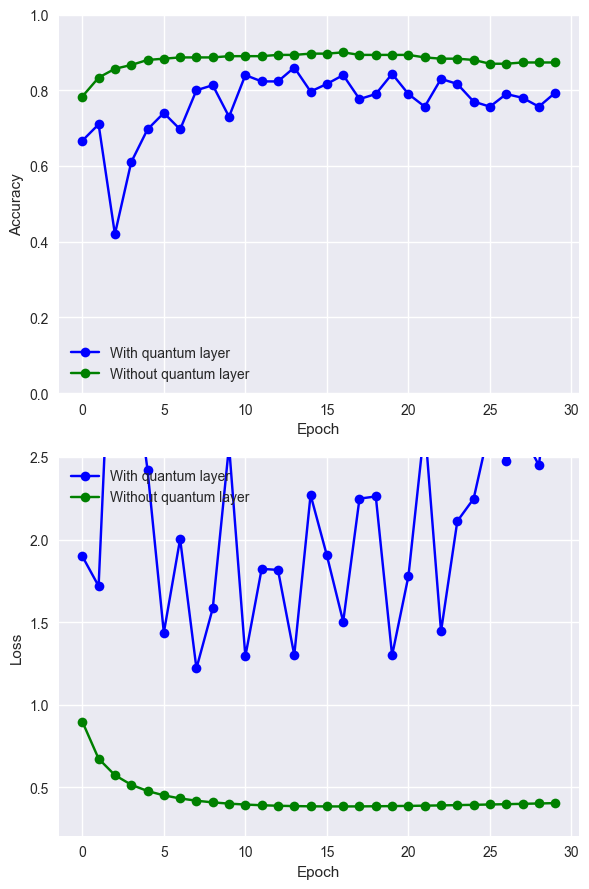

In [42]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
